In [3323]:
"""
Created on Tuesday 1 May 2023
Author: ZAW
"""
#import libraries
import numpy as np
import pandas as pd
import os
from scipy.optimize import curve_fit
import warnings
warnings.simplefilter("ignore")

### Load the subject and stiumuls repect to their speed

### Subjects

In [3324]:
path = os.getcwd()
dirname = os.path.dirname(path)
# for HC
data_file = 'data/one_deg.csv'
# # for PD
#data_file = 'data/PD/one_deg.csv'

data_path = os.path.join(dirname,data_file)
# data = pd.read_csv(data_path)
data= pd.read_csv(data_path)

data_hc = data[['x1_PD002','y1_PD002']] # change the ID each subject code(e.g PD001 or PD003)
y_data = data_hc[data_hc.columns[0]]
x_data = data_hc[data_hc.columns[1]]

#### For stimulus

In [3325]:
#import CSV data
path = os.getcwd()
dirname = os.path.dirname(path)
data_file = 'data/1_degSti.xlsx'
data_path = os.path.join(dirname,data_file)
rawdata = pd.read_excel(data_path)
data_st = np.array(rawdata[1:],dtype=np.float)
time = data_st[:,1]
position = data_st[:,0]

### Trigonometric functions

In [3326]:
# Trigonometric functions

# Define the function
def func(x, a, b, c):  #Position as a function of time.
    return a*(2/np.pi)*np.arcsin(np.sin(np.pi*(b*x+c)))

#initial guesses( This has to change depend on stimulus speed)
#for 1 degree per second: [10, 0.05, 0]
#for 2 degrees per second: [10, 0.1, 0]
#for 4 degrees per second: [10, 0.2, 0]
#for 6 degrees per second: [10, 0.3, 0]
#for 8 degrees per second: [10, 0.4, 0]
InitialGuess = [10, 0.05, 0] # for one degree

# Perform curve fitting
popt, pcov = curve_fit(func,position,time, p0=InitialGuess)

# Extract the optimal values of a, b, and c
a, b, c = popt
# print("a =", a)
# print("b =", b)
# print("c =", c)

# Fit the curve
fit_time = func(y_data,a,b,c)
# plt.plot(y_data,fit_time)
# plt.show()

### Find the residual

In [3327]:
# Different(aka residual)
diff = x_data - fit_time

dt_array = np.array(diff)
dt_array = pd.DataFrame(dt_array,columns=['diff'])
window_size = 2
dt_array['Moving_Average'] = dt_array['diff'].rolling(window=window_size).mean()
#plt.plot(y_data,dt_array['Moving_Average'])
# create dataframe
data = {'Time':y_data,'POS':dt_array['Moving_Average']}
df = pd.DataFrame(data)

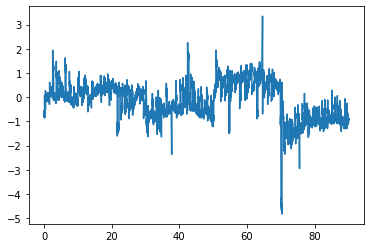

In [3328]:
import matplotlib.pyplot as plt
plt.plot(y_data,dt_array['Moving_Average'])

#### The whole dataset

In [3329]:
# Plot specific range
x_start = 10.01
x_end = 90.00

# Filter the data points within the disired range using boolean indexing
mask = (df['Time'] >= x_start) & (df['Time'] <= x_end)
x_data_range = df.loc[mask]

data = {'Time':x_data_range['Time'],'POS':x_data_range['POS']}
df_test = pd.DataFrame(data)

### Determine the integration window

In [3330]:
# Determine the integration window
def check_sign(x):
    if x > 0:
        return "Positive"
    else:
        return "Negative"
df_test['Sign'] = df_test['POS'].apply(check_sign)

In [3331]:
df_test

,Time,POS,Sign
3002,10.0100,0.330478,Positive
3003,10.0133,0.232975,Positive
3004,10.0167,0.226271,Positive
3005,10.0200,0.380818,Positive
3006,10.0233,0.293365,Positive
...,...,...,...
26995,89.9867,-1.033620,Negative
26996,89.9900,-0.996667,Negative
26997,89.9933,-0.909213,Negative
26998,89.9967,-0.862160,Negative


### Condition of the window

In [3332]:
# Condition window width 
def calculate_start_end(row):
    global last_positive, last_negative
    if row['Sign'] == 'Positive':
        if row.name == 0 or df_test.loc[row.name - 1, 'Sign'] != 'Positive':
            last_positive = row['Time']
            return last_positive, '', '', ''
        elif row.name < len(df_test) - 1 and df_test.loc[row.name + 1, 'Sign'] != 'Positive':
            pos_end = row['Time']
            last_positive = ''
            return '', pos_end, '', ''
        else:
            return '', '', '', ''
    elif row['Sign'] == 'Negative':
        if row.name == 0 or df_test.loc[row.name - 1, 'Sign'] != 'Negative':
            last_negative = row['Time']
            return '', '', last_negative, ''
        elif row.name < len(df_test) - 1 and df_test.loc[row.name + 1, 'Sign'] != 'Negative':
            last_negative = row['Time']
            return '', '', '', last_negative
        else:
            return '', '', '', ''
    else:
        return '', '', '', ''

# Initialize the last positive and negative values to empty strings 
last_positive = ''
last_negative = ''

# Reset the index of the DataFrame
df_test = df_test.reset_index(drop=True)

# Apply the custom function to create new columns
df_test['PosTim_Start'], df_test['PosTim_End'], df_test['NegTim_Start'], df_test['NegTim_End'] = zip(*df_test.apply(calculate_start_end, axis=1))

# Fill the empty cells with an empty string
df_test['PosTim_Start'] = df_test['PosTim_Start'].fillna('') 
df_test['PosTim_End'] = df_test['PosTim_End'].fillna('')
df_test['NegTim_Start'] = df_test['NegTim_Start'].fillna('')
df_test['NegTim_End'] = df_test['NegTim_End'].fillna('')

# Print the resulting dataframe 
#print(df_test)

In [3333]:
df_test.to_csv("df_test.csv")

#### Positive Time Start Trimming

In [3334]:
# Select the non-empty values in the 'Pos_Start' column
pos_start_values = df_test.loc[df_test['PosTim_Start'] != '', 'PosTim_Start'].values

# Round the values in the 'Pos_Start' column to two decimal places
# rounded_pos_start_values = []
# for value in pos_start_values:
#     rounded_pos_start_values.append(round(value - 0.003, 2))

# Convert the list of rounded values back to a NumPy array
postim_start_values = np.array(pos_start_values)

# Print the non-empty values
#print(postim_start_values)

#### Poisitive Time end Trimming

In [3335]:
# Select the non-empty values in the 'Pos_End' column
pos_end_values = df_test.loc[df_test['PosTim_End'] != '', 'PosTim_End'].values

# Round the values in the 'Pos_End' column to two decimal places
# rounded_pos_end_values = []
# for value in pos_end_values:
#     rounded_pos_end_values.append(round(value - 0.02, 2))

# Convert the list of rounded values back to a NumPy array
postim_end_values = np.array(pos_end_values)

# Print the non-empty values
#print(postim_end_values)

### Reload the raw data for mapping

In [3336]:
# Reload the raw data for mapping
data = data_hc.rename(columns={data_hc.columns.values[0]:"Position",
                               data_hc.columns.values[1]:'Time'})

#### Map the start positive Time to POS in raw data

In [3337]:
# Create a dictionary from the mapping list
mapping_list = postim_start_values

# Map the values to the 'POS' column in raw
mapped_posSt = data.loc[data['Position'].isin(mapping_list),'Time']

#### Map the End positive Time to POS in raw data

In [3338]:
# Create a dictionary from the mapping list
mapping_list = postim_end_values

# Map the values to the 'POS' column in raw
mapped_posEnd = data.loc[data['Position'].isin(mapping_list),'Time']


#### Velocity param positive dataframe

In [3339]:
# # column miss match
# Check lengths and truncate longer column 
if len(postim_start_values) > len(mapped_posSt): 
    postim_start_values = postim_start_values[:len(mapped_posSt)] 
elif len(mapped_posSt) > len(postim_start_values):
    mapped_posSt = mapped_posSt[:len(postim_start_values)]      

# Now columns have equal length 
data_param = {'positive_x1':postim_start_values,'positive_y1':mapped_posSt}             
param_vel_start = pd.DataFrame(data_param)

data_param= {'positive_x2':postim_end_values,'positive_y2':mapped_posEnd}
param_vel_end = pd.DataFrame(data_param)

# Reset the indices of the DataFrames
param_vel_start = param_vel_start.reset_index(drop=True)
param_vel_end = param_vel_end.reset_index(drop=True)

# Concatenate the DataFrames horizontally
param_vel_positive_final = pd.concat([param_vel_start,param_vel_end],axis=1)
#param_vel_positive_final['Del_X'] = param_vel_positive_final['positive_x2'] - param_vel_positive_final['positive_x1']

param_vel_positive_final['Del_X'] = (param_vel_positive_final['positive_x2'] - 
                                     param_vel_positive_final['positive_x1']).where(~param_vel_positive_final['positive_x2'].isnull(), np.nan)



# # Remove short duration SWJ from 50 ms to 400 ms
param_vel_positive_final = param_vel_positive_final[(param_vel_positive_final['Del_X'] > 0.4) & 
                                                    (param_vel_positive_final['Del_X'] < 2.00)]


# iterate over the rows of the dataframe
prev_positive_x2 = None
for i, row in param_vel_positive_final.iterrows():
    # check if this is not the first row
    if prev_positive_x2 is not None:
        # check if positive_x1 is lower than the previous positive_x2
        if row['positive_x1'] < prev_positive_x2:
            # remove this row from the dataframe
            param_vel_positive_final = param_vel_positive_final.drop(i)
        else:
            # update prev_positive_x2 if positive_x1 is greater than or equal to prev_positive_x2
            prev_positive_x2 = row['positive_x2']
    else:
        # initialize prev_positive_x2 with the first row value
        prev_positive_x2 = row['positive_x2']


# iterate over the rows of the dataframe
# for i, row in param_vel_positive_final.iterrows():
#     # check if Del_X is not NaN
#     if not np.isnan(row['Del_X']):
#         # apply the other conditions on Del_X
#           param_vel_positive_final = param_vel_positive_final[(param_vel_positive_final['Del_X'] > 0.3) & 
#                                                     (param_vel_positive_final['Del_X'] < 2.07)]
        


#param_vel_positive_final = param_vel_positive_final[param_vel_positive_final['Del_X'] < 2.07]
#                                                     (param_vel_positive_final['Del_X'] < 1.997)]



#param_vel_positive_final = param_vel_positive_final.fillna(method='ffill')
#param_gain_final
#param_vel_positive_final


In [3340]:
param_vel_positive_final

,positive_x1,positive_y1,positive_x2,positive_y2,Del_X
0,10.01,10.4032,11.2533,8.7298,1.2433
11,11.5733,8.4476,12.9467,7.1371,1.3734
18,13.2433,6.7944,13.9433,6.0081,0.7
37,19.32,0.7258,19.7367,0.3427,0.4167
59,25.4633,-5.1411,27.36,-7.3589,1.8967
82,27.37,-7.2782,28.7833,-8.8306,1.4133


In [3341]:
param_vel_positive_final['Del_X'].sum()

7.043399999999998

#### Conditions

In [3342]:
# param_vel_positive_final['Condition'] = param_vel_positive_final['positive_x2'] - param_vel_positive_final['positive_x1']
# param_vel_positive_final['Condition'] =abs(param_vel_positive_final['Condition'])
# param_vel_positive_final = param_vel_positive_final[param_vel_positive_final['Condition'] > 0.72]

### Velocity for Positive peak calculation

In [3343]:
# Calculate the difference between y2 and y1 divided by the difference between x2 and x1
param_vel_positive_final['slope'] = (param_vel_positive_final['positive_y2'] - param_vel_positive_final['positive_y1']) / (param_vel_positive_final['positive_x2'] - param_vel_positive_final['positive_x1'])

# abs
param_vel_positive_final['slope'] = abs(param_vel_positive_final['slope'])

# Reindexing
param_vel_positive_final = param_vel_positive_final.reset_index(drop=True)

# Remove unwant values
#param_gain_positive_final.loc[param_gain_positive_final['slope'] > 1.09, 'slope'] = np.nan  

# Calculate the average slope
average_positive_slope = abs(param_vel_positive_final['slope'].mean())

# Print the average slope
#print(average_positive_slope)

#### Negative Time Start Trimming

In [3344]:
# Select the non-empty values in the 'Pos_Start' column
neg_start_values = df_test.loc[df_test['NegTim_Start'] != '', 'NegTim_Start'].values

# Round the values in the 'Pos_Start' column to two decimal places
rounded_neg_start_values = []
for value in neg_start_values:
    rounded_neg_start_values.append(round(value - 0.003, 2))

# Convert the list of rounded values back to a NumPy array
negtim_start_values = np.array(rounded_neg_start_values)

# Print the non-empty values
#print(negtim_start_values)

#### Negative Time End Trimming

In [3345]:
# Select the non-empty values in the 'Pos_Start' column
neg_end_values = df_test.loc[df_test['NegTim_End'] != '', 'NegTim_End'].values

# Round the values in the 'Pos_Start' column to two decimal places
# rounded_neg_end_values = []
# for value in neg_end_values:
#     rounded_neg_end_values.append(round(value - 0.02, 2))

# Convert the list of rounded values back to a NumPy array
negtim_end_values = np.array(neg_end_values)

# Print the non-empty values
#print(negtim_end_values)

#### Map the start negative Time to POS in raw data

In [3346]:
# Create a dictionary from the mapping list
mapping_list = negtim_start_values

# Map the values to the 'POS' column in raw
mapped_negSt = data.loc[data['Position'].isin(mapping_list),'Time']

#### Map the End of negative Time to POS in raw data

In [3347]:
# Create a dictionary from the mapping list
mapping_list = negtim_end_values

# Map the values to the 'POS' column in raw
mapped_negEnd = data.loc[data['Position'].isin(mapping_list),'Time']

#### Velocity param negative dataframe

In [3348]:
# column miss match
# Check lengths and truncate longer column 
if len(negtim_start_values) > len(mapped_negSt): 
    negtim_start_values = negtim_start_values[:len(mapped_negSt)] 
elif len(mapped_negSt) > len(negtim_start_values):
    mapped_negSt = mapped_negSt[:len(negtim_start_values)]  


data_param = {'negative_x1':negtim_start_values,'negative_y1':mapped_negSt}             
param_vel_start = pd.DataFrame(data_param)
data_param= {'negative_x2':negtim_end_values,'negative_y2':mapped_negEnd}
param_vel_end = pd.DataFrame(data_param)

# Reset the indices of the DataFrames
param_vel_start = param_vel_start.reset_index(drop=True)
param_vel_end = param_vel_end.reset_index(drop=True)

# Concatenate the DataFrames horizontally
param_vel_negative_final = pd.concat([param_vel_start,param_vel_end],axis=1)
param_vel_negative_final['Del_X'] = param_vel_negative_final['negative_x2'] - param_vel_negative_final['negative_x1']
#param_vel_negative_final = param_vel_negative_final.fillna(method='ffill')
#param_vel_negative_final

# Remove short duration
# param_vel_negative_final = param_vel_negative_final[(param_vel_negative_final['Del_X'] > 0.3) & 
#                                                     (param_vel_negative_final['Del_X'] < 2.07)]
param_vel_negative_final = param_vel_negative_final[param_vel_negative_final['Del_X'] < 2.07]
#                                                     
param_vel_negative_final['Del_X'] = (param_vel_negative_final['negative_x2'] - 
                                     param_vel_negative_final['negative_x1']).where(~param_vel_negative_final['negative_x2'].isnull(), np.nan)



# # Remove short duration SWJ from 50 ms to 400 ms
param_vel_negative_final = param_vel_negative_final[(param_vel_negative_final['Del_X'] > 0.4) & 
                                                    (param_vel_negative_final['Del_X'] < 2.00)]


# iterate over the rows of the dataframe
prev_negative_x2 = None
for i, row in param_vel_negative_final.iterrows():
    # check if this is not the first row
    if prev_negative_x2 is not None:
        # check if positive_x1 is lower than the previous positive_x2
        if row['negative_x1'] < prev_negative_x2:
            # remove this row from the dataframe
            param_vel_negative_final = param_vel_negative_final.drop(i)
        else:
            # update prev_positive_x2 if positive_x1 is greater than or equal to prev_positive_x2
            prev_megatove_x2 = row['negative_x2']
    else:
        # initialize prev_positive_x2 with the first row value
        prev_negative_x2 = row['negative_x2']

#### Conditions

In [3349]:
# param_vel_negative_final['Condition'] = param_vel_negative_final['negative_x2'] - param_vel_negative_final['negative_x1']
# param_vel_negative_final['Condition'] =abs(param_vel_negative_final['Condition'])
# param_vel_negative_final = param_vel_negative_final[param_vel_negative_final['Condition'] > 1.01]

In [3350]:
param_vel_negative_final

,negative_x1,negative_y1,negative_x2,negative_y2,Del_X
14,11.70,8.2460,13.24,6.7137,1.54
29,13.89,6.0887,14.4,5.4839,0.51
59,25.52,-5.4966,27.2167,-7.1573,1.6967
60,26.16,-6.0685,27.2267,-7.2984,1.0667
67,27.07,-7.0565,28.27,-8.3871,1.2
68,27.11,-6.9960,28.28,-8.3266,1.17
69,27.12,-7.0363,28.31,-8.3065,1.19
70,27.16,-7.2782,28.3233,-8.2460,1.1633
71,27.17,-7.3589,28.3633,-8.3065,1.1933
72,27.18,-7.1774,28.3833,-8.3266,1.2033


In [3351]:
param_vel_negative_final['Del_X'].sum()

33.639700000000005

### Velocity for Negative peak calculation

In [3352]:
# Calculate the difference between y2 and y1 divided by the difference between x2 and x1
param_vel_negative_final['slope'] = (param_vel_negative_final['negative_y2']
                                     - param_vel_negative_final['negative_y1']) / (param_vel_negative_final['negative_x2'] 
                                     - param_vel_negative_final['negative_x1'])

# abs
param_vel_negative_final['slope'] = abs(param_vel_negative_final['slope'])

param_vel_negative_final['slope'].replace([np.inf, -np.inf], np.nan, inplace=True)

# Reindexing
param_vel_negative_final = param_vel_negative_final.reset_index(drop=True)

# Remove unwant values
#param_gain_negative_final.loc[(param_gain_negative_final['slope'] < 0.80) |  
#                              (param_gain_negative_final['slope'] > 1.09), 
#                              'slope'] = np.nan
# Calculate the average slope
average_negative_slope = abs(param_vel_negative_final['slope'].mean())

# Print the average slope
#print(average_negative_slope)

In [3353]:
param_vel_negative_final

,negative_x1,negative_y1,negative_x2,negative_y2,Del_X,slope
0,11.70,8.2460,13.24,6.7137,1.54,0.995000
1,13.89,6.0887,14.4,5.4839,0.51,1.185882
2,25.52,-5.4966,27.2167,-7.1573,1.6967,0.978782
3,26.16,-6.0685,27.2267,-7.2984,1.0667,1.152995
4,27.07,-7.0565,28.27,-8.3871,1.2,1.108833
5,27.11,-6.9960,28.28,-8.3266,1.17,1.137265
6,27.12,-7.0363,28.31,-8.3065,1.19,1.067395
7,27.16,-7.2782,28.3233,-8.2460,1.1633,0.831944
8,27.17,-7.3589,28.3633,-8.3065,1.1933,0.794100
9,27.18,-7.1774,28.3833,-8.3266,1.2033,0.955040


### Total velocity for both positive and negative

In [3354]:
Final_Vel = pd.concat([param_vel_positive_final[['Del_X','slope']],
                       param_vel_negative_final[['Del_X','slope']]], axis=0, join='outer')

In [3355]:
# Final_Vel = param_vel_positive_final[['Del_X','slope']]
                      

In [3356]:
Final_Vel

,Del_X,slope
0,1.2433,1.345934
1,1.3734,0.954201
2,0.7,1.123286
3,0.4167,0.919366
4,1.8967,1.169294
5,1.4133,1.098422
0,1.54,0.995
1,0.51,1.185882
2,1.6967,0.978782
3,1.0667,1.152995


### Counter check with duration and velocity

In [3357]:
Final_Vel['Checked_velocity'] = Final_Vel['slope'] * Final_Vel['Del_X']
Vel = Final_Vel['Checked_velocity'].sum()/Final_Vel['Del_X'].sum()
Vel

1.0374184858086035

In [3358]:
Final_Vel['Del_X'].sum()

40.68310000000001

### Calculate Gain

In [3359]:
speed = 1 # stimulus speed
total_gain = Vel/speed
print("The gain for this subject is:",total_gain)

The gain for this subject is: 1.0374184858086035
